## Import Header

In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from zipfile import ZipFile
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.data.experimental import cardinality
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom, RandomRotation

from tensorflow.keras.applications import efficientnet, EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [2]:
random.seed(1337)
np.random.seed(1337)
tf.random.set_seed(1337)

def unzip(nm):
    with ZipFile(nm,"r") as zip:
        zip.extractall()

unzip("archive.zip")

In [3]:
train_ds = image_dataset_from_directory(
    "TB_Chest_Radiography_Database",
    validation_split = 0.2,
    subset = "training",
    seed = 1337,
    shuffle = True,
    image_size = (256,256),
    batch_size = 32,
)

val_ds = image_dataset_from_directory(
    "TB_Chest_Radiography_Database",
    validation_split = 0.2,
    subset = "validation",
    seed = 1337,
    shuffle = True,
    image_size = (256,256),
    batch_size = 32,
)

Found 4200 files belonging to 2 classes.
Using 3360 files for training.
Found 4200 files belonging to 2 classes.
Using 840 files for validation.


## Plot some images

['Normal', 'Tuberculosis']


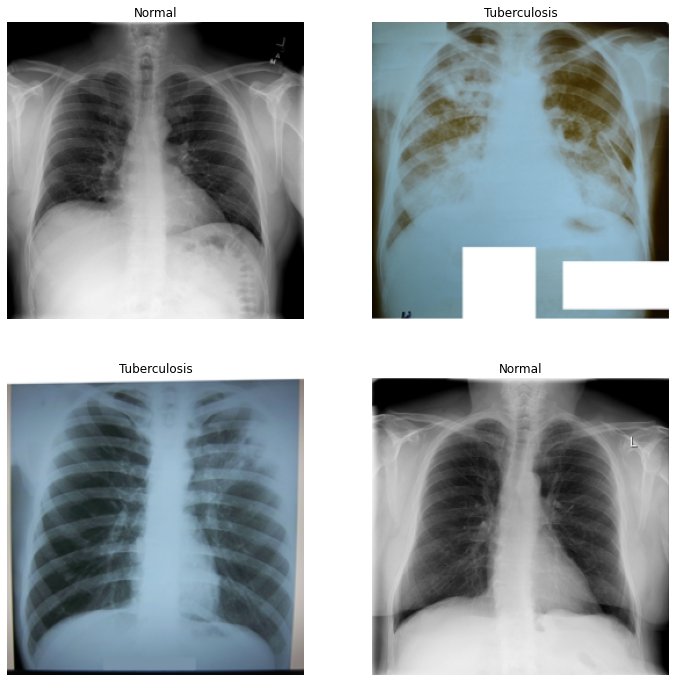

In [4]:
val_batches = cardinality(val_ds)
test_ds = val_ds.take(val_batches//5)
val_ds = val_ds.skip(val_batches//5)

class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(12,12))
for images,labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Define the model (Transfer Learning feature extraction)

In [5]:
data_augmentation = Sequential([
    RandomZoom(0.2),
    RandomRotation(0.1),
])

rescale = efficientnet.preprocess_input

base_model = EfficientNetB3(input_shape=(256,256,3),include_top=False,weights="imagenet")
image_batch,label_batch = next(iter(train_ds))

base_model.trainable = False
base_model.summary()

class Transfer_Efficient():
    def model(self,input):
        self.x = data_augmentation(input)
        self.x = rescale(self.x)
        self.x = base_model(self.x,training=False)
        self.x = GlobalAveragePooling2D()(self.x)
        self.x = Dropout(0.2,seed=1337)(self.x)
        self.outputs = Dense(2,activation="sigmoid")(self.x)
        self.model = Model(input,self.outputs,name="Transfer_EfficientB3")
        return self.model

TEB3 = Transfer_Efficient()
model = TEB3.model(Input(shape=(256,256,3)))
model.summary()
model.compile(Adam(),SparseCategoricalCrossentropy(),metrics=["accuracy"])

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

Model: "Transfer_EfficientB3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 8, 8, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3074      
Total params: 10,786,609
Trainable params: 3,074
Non-trainable params: 10,783,535
______________________________

In [6]:
if __name__=="__main__":
    loss0,accuracy0 = model.evaluate(val_ds)
    print("Initial loss: {:.2f} %".format(100*loss0))
    print("Initial accuracy: {:.2f} %".format(100*accuracy0))
    checkpoint = ModelCheckpoint("tuberculosis.hdf5",save_weights_only=False,monitor="val_loss",save_best_only=True)
    model.fit(train_ds,epochs=10,validation_data=val_ds,callbacks=[checkpoint])
    best = load_model("tuberculosis.hdf5")
    val_loss,val_accuracy = best.evaluate(val_ds)
    test_loss,test_accuracy = best.evaluate(test_ds)
    print("\nVal accuracy: {:.2f} %".format(100*val_accuracy))
    print("Val loss: {:.2f} %".format(100*val_loss))
    print("\nTest accuracy: {:.2f}".format(100*test_accuracy))
    print("Test loss: {:.2f} %".format(100*test_loss))

22/22 [==============================] - 12s 304ms/step - loss: 0.5525 - accuracy: 0.7868
Initial loss: 55.25 %
Initial accuracy: 78.68 %
Epoch 1/10
105/105 [==============================] - 40s 332ms/step - loss: 0.2143 - accuracy: 0.9146 - val_loss: 0.1878 - val_accuracy: 0.9206


/home/maverick/.local/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
105/105 [==============================] - 34s 320ms/step - loss: 0.1272 - accuracy: 0.9536 - val_loss: 0.1322 - val_accuracy: 0.9426
Epoch 3/10
105/105 [==============================] - 34s 318ms/step - loss: 0.1061 - accuracy: 0.9598 - val_loss: 0.1478 - val_accuracy: 0.9397
Epoch 4/10
105/105 [==============================] - 35s 335ms/step - loss: 0.0888 - accuracy: 0.9738 - val_loss: 0.1296 - val_accuracy: 0.9456
Epoch 5/10
105/105 [==============================] - 34s 323ms/step - loss: 0.0844 - accuracy: 0.9711 - val_loss: 0.1314 - val_accuracy: 0.9485
Epoch 6/10
105/105 [==============================] - 34s 321ms/step - loss: 0.0798 - accuracy: 0.9720 - val_loss: 0.1360 - val_accuracy: 0.9529
Epoch 7/10
105/105 [==============================] - 34s 324ms/step - loss: 0.0755 - accuracy: 0.9723 - val_loss: 0.1355 - val_accuracy: 0.9456
Epoch 8/10
105/105 [==============================] - 34s 322ms/step - loss: 0.0684 - accuracy: 0.9732 - val_loss: 0.1191 - val_ac